In [1]:
import pandas as pd

# Veri setini yükleme
file_path = 'DataSet.xlsx'  # Dosya adını uygun şekilde değiştirin
df = pd.read_excel(file_path)

# Eksik veri kontrolü
missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Veri türlerini kontrol etme
data_types = df.dtypes

# Eksik veri raporu
missing_report = pd.DataFrame({
    'Missing Values': missing_data,
    'Missing Percentage': missing_percentage,
    'Data Type': data_types
})

print("Eksik Veri Raporu:")
print(missing_report)

Eksik Veri Raporu:
         Missing Values  Missing Percentage       Data Type
Ör.No                 0            0.000000           int64
Ay                    0            0.000000  datetime64[ns]
Eşey                  0            0.000000          object
TB                    0            0.000000         float64
CB                    0            0.000000         float64
CE                    0            0.000000         float64
AB                    0            0.000000         float64
AE                    0            0.000000         float64
KABsağ                0            0.000000          object
KABsol                0            0.000000          object
MBsağ                 0            0.000000          object
MBsol                 0            0.000000          object
MEsağ                 0            0.000000          object
MEsol                 0            0.000000          object
CA                    0            0.000000         float64
AA                   

## Eksik Verileri Doldurma

In [2]:
# Kategorik sütunlarda eksik verileri mod (en sık tekrar eden değer) ile doldurma
categorical_columns = ['ANBsağ', 'ANBsol', 'TRBsağ1', 'TRBsağ2']

for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Eksik veri kontrolünü tekrar yapalım
print("Eksik Veri Kontrolü (Doldurma Sonrası):")
print(df.isnull().sum())

Eksik Veri Kontrolü (Doldurma Sonrası):
Ör.No      0
Ay         0
Eşey       0
TB         0
CB         0
CE         0
AB         0
AE         0
KABsağ     0
KABsol     0
MBsağ      0
MBsol      0
MEsağ      0
MEsol      0
CA         0
AA         0
MAsağ      0
MAsol      0
MEAsağ     0
MEAsol     0
AEA        0
ANBsağ     0
ANBsol     0
TRBsağ1    0
TRBsağ2    0
TA         0
dtype: int64


## Korelasyon Tabanlı Seçim

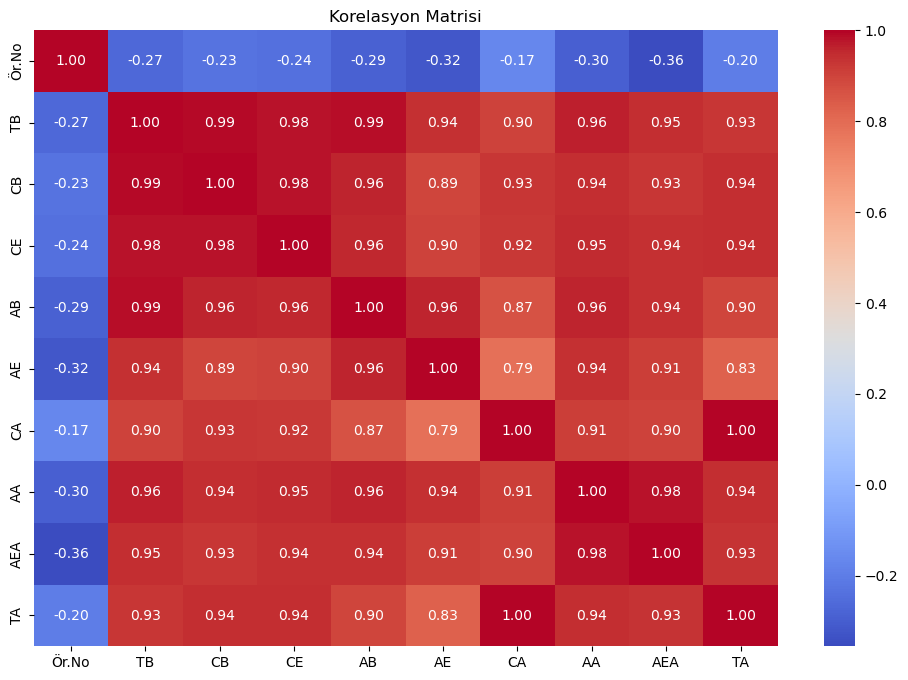

Yüksek Korelasyona Sahip Değişkenler (TA ile): ['TB', 'CB', 'CE', 'AB', 'AE', 'CA', 'AA', 'AEA', 'TA']


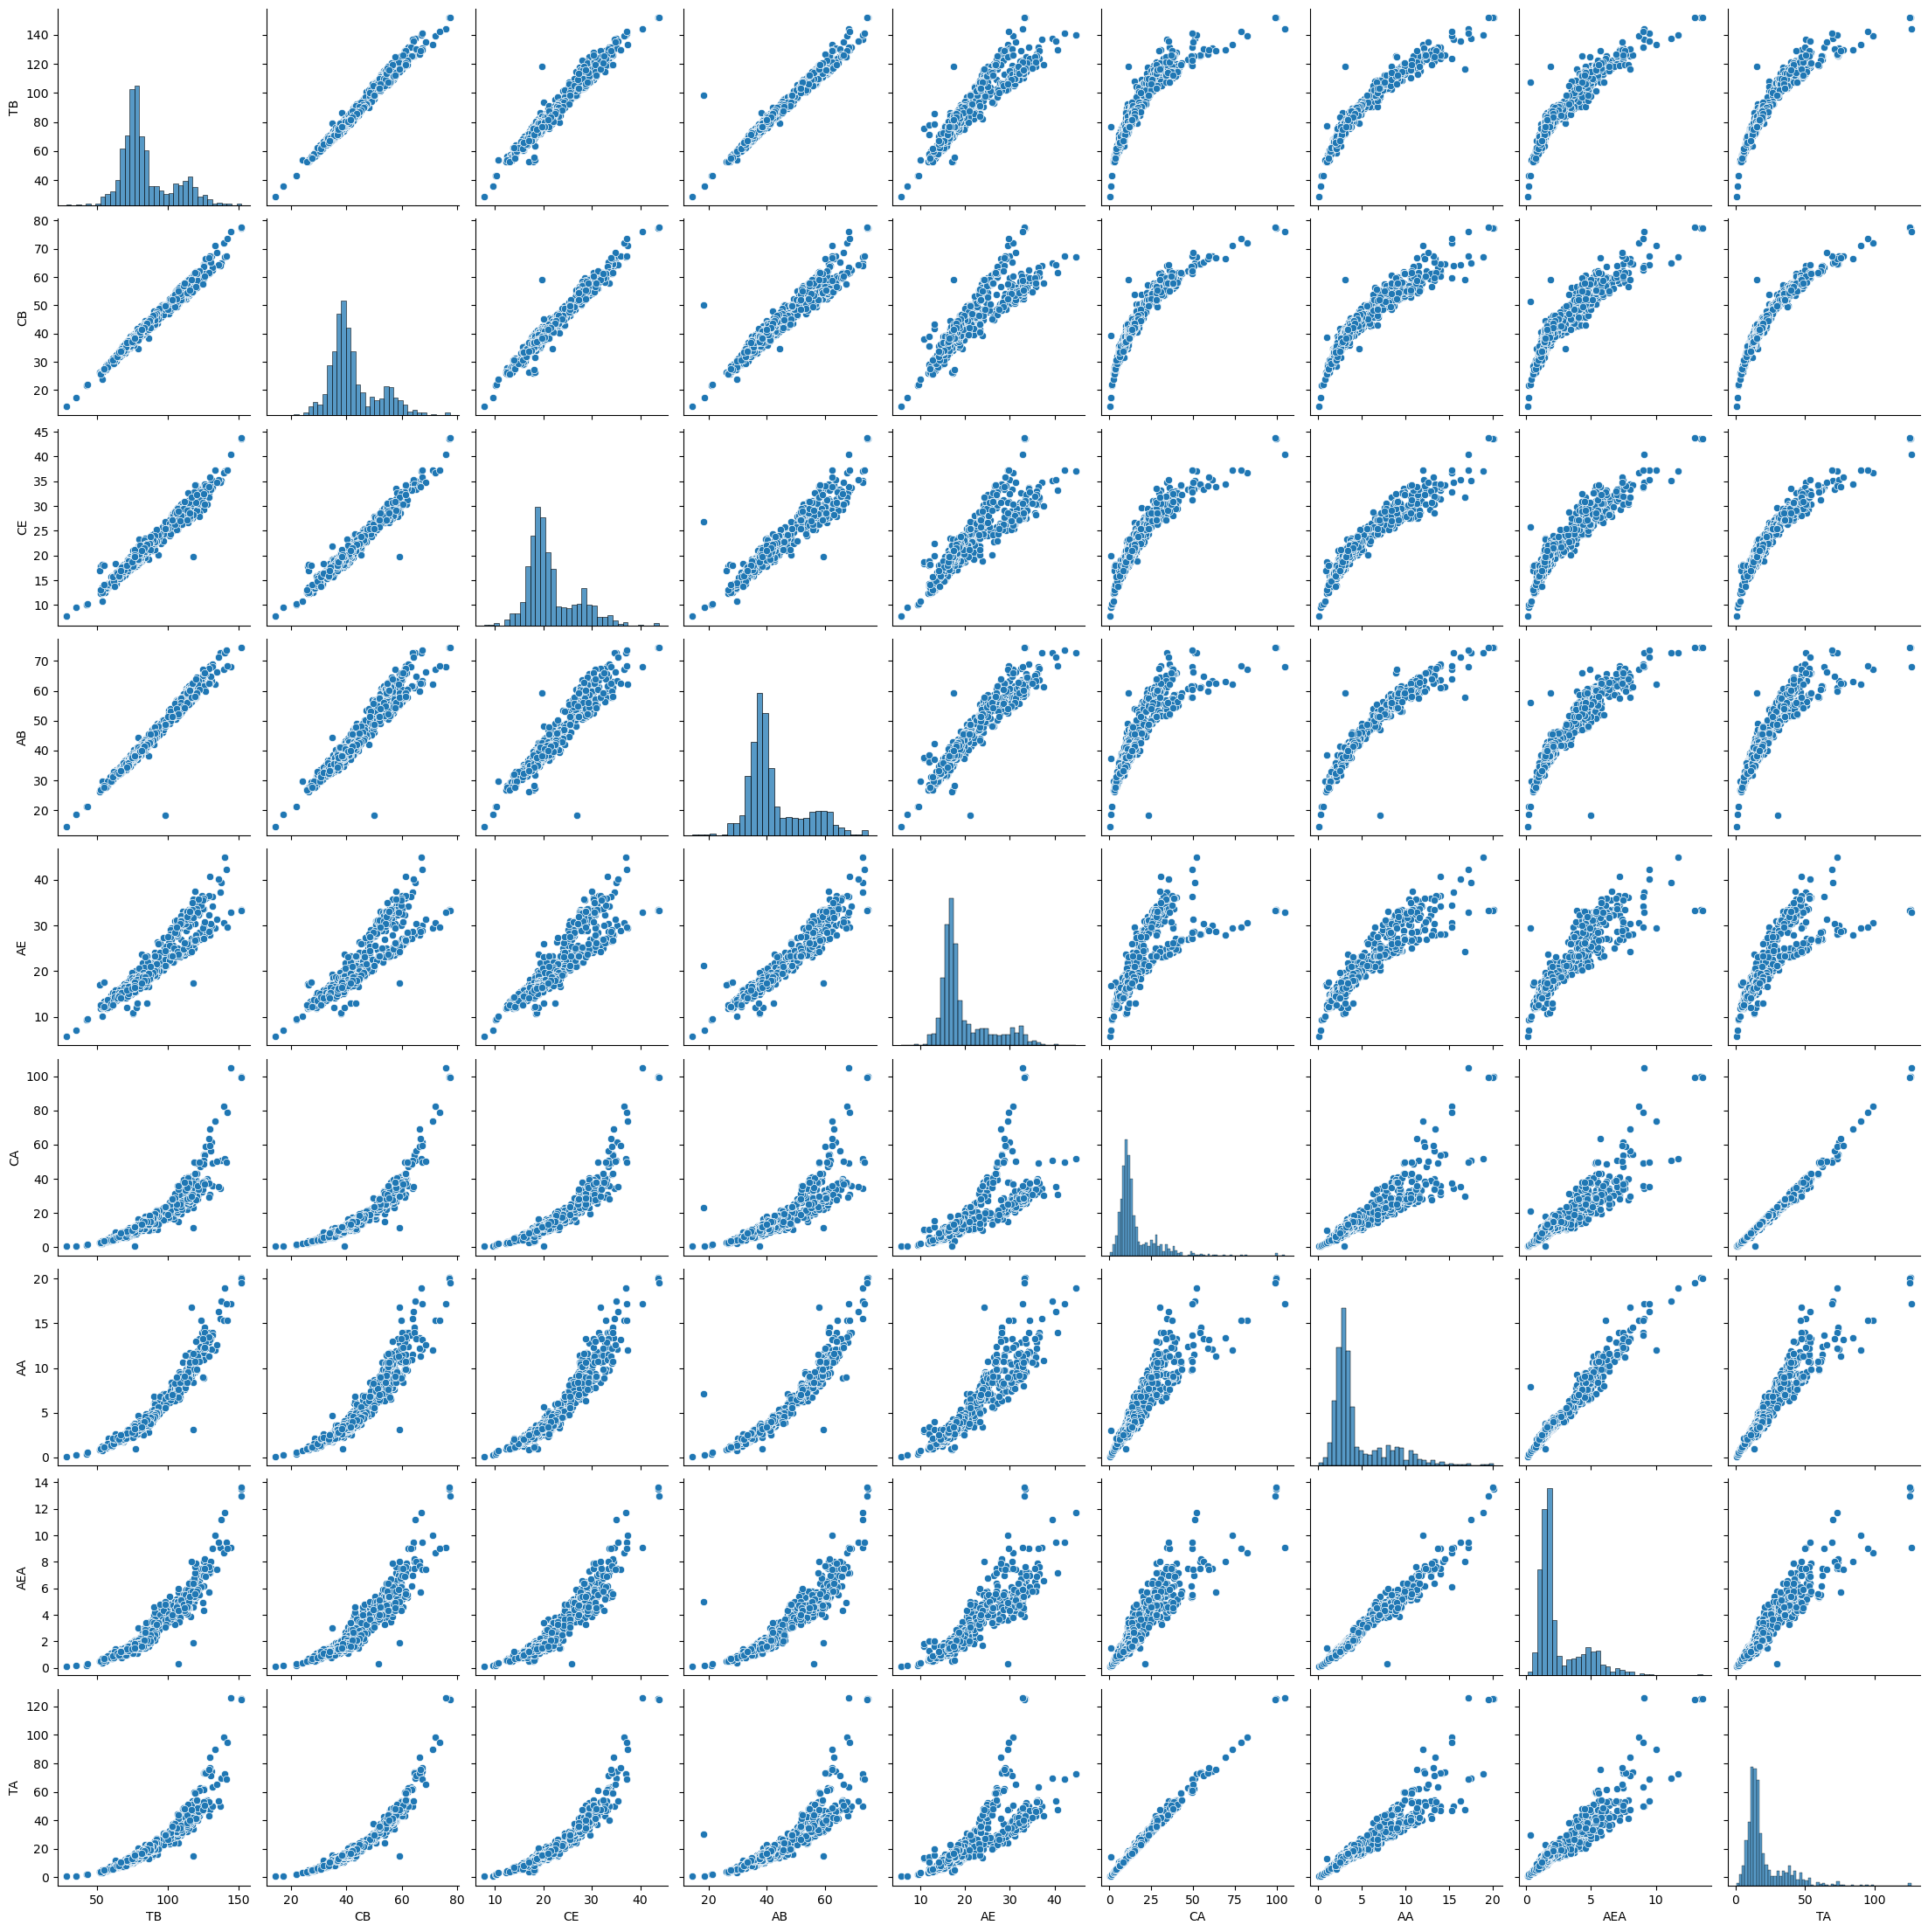

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Korelasyon matrisini hesaplayalım
# Sadece sayısal sütunları seçerek korelasyon matrisini hesaplıyoruz
numeric_df = df.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()

# Korelasyon matrisi ısı haritası
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelasyon Matrisi")
plt.show()

# Korelasyon eşik değeri belirleme
threshold = 0.5
high_corr_features = correlation_matrix['TA'][abs(correlation_matrix['TA']) > threshold].index.tolist()
print("Yüksek Korelasyona Sahip Değişkenler (TA ile):", high_corr_features)

# Yüksek korelasyonlu değişkenlerle saçılım matrisi
sns.pairplot(df[high_corr_features])
plt.show()

## Varyans Tabanlı Seçim

In [4]:
from sklearn.feature_selection import VarianceThreshold

# Varyans tabanlı seçim için yalnızca sayısal sütunlar
numeric_df = df.select_dtypes(include=['number'])

# Varyans eşiğini belirleme (örneğin 0.01)
variance_threshold = 0.01
selector = VarianceThreshold(threshold=variance_threshold)

# Varyans filtresi uygulama
numeric_selected = selector.fit_transform(numeric_df)

# Seçilen değişkenlerin isimlerini almak
selected_features = numeric_df.columns[selector.get_support()]
print("Varyans Tabanlı Seçim ile Seçilen Değişkenler:", selected_features)

# Yeni veri çerçevesini oluşturma
df_variance_selected = df[selected_features]

Varyans Tabanlı Seçim ile Seçilen Değişkenler: Index(['Ör.No', 'TB', 'CB', 'CE', 'AB', 'AE', 'CA', 'AA', 'AEA', 'TA'], dtype='object')


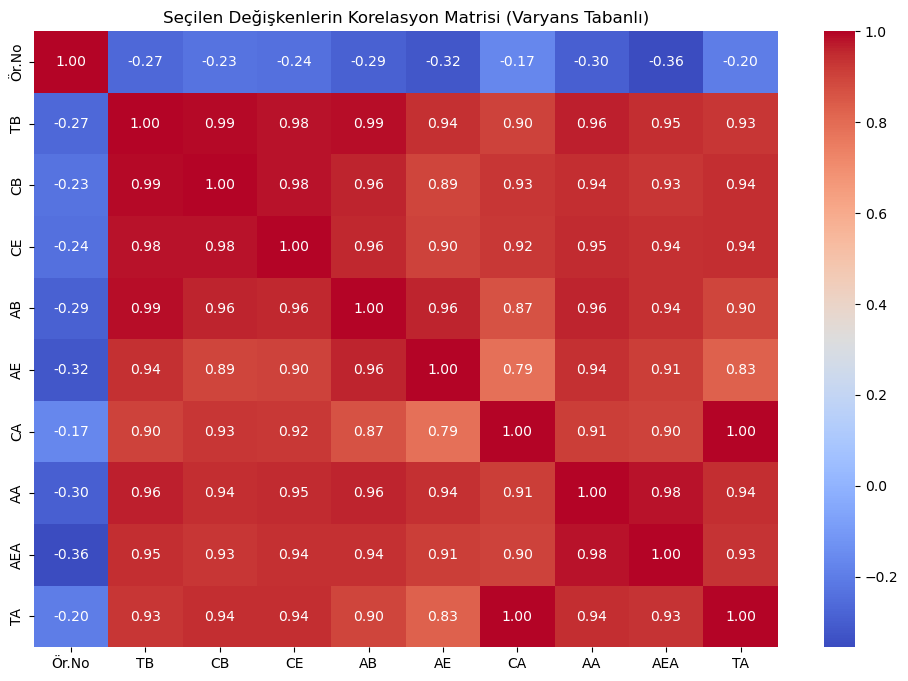

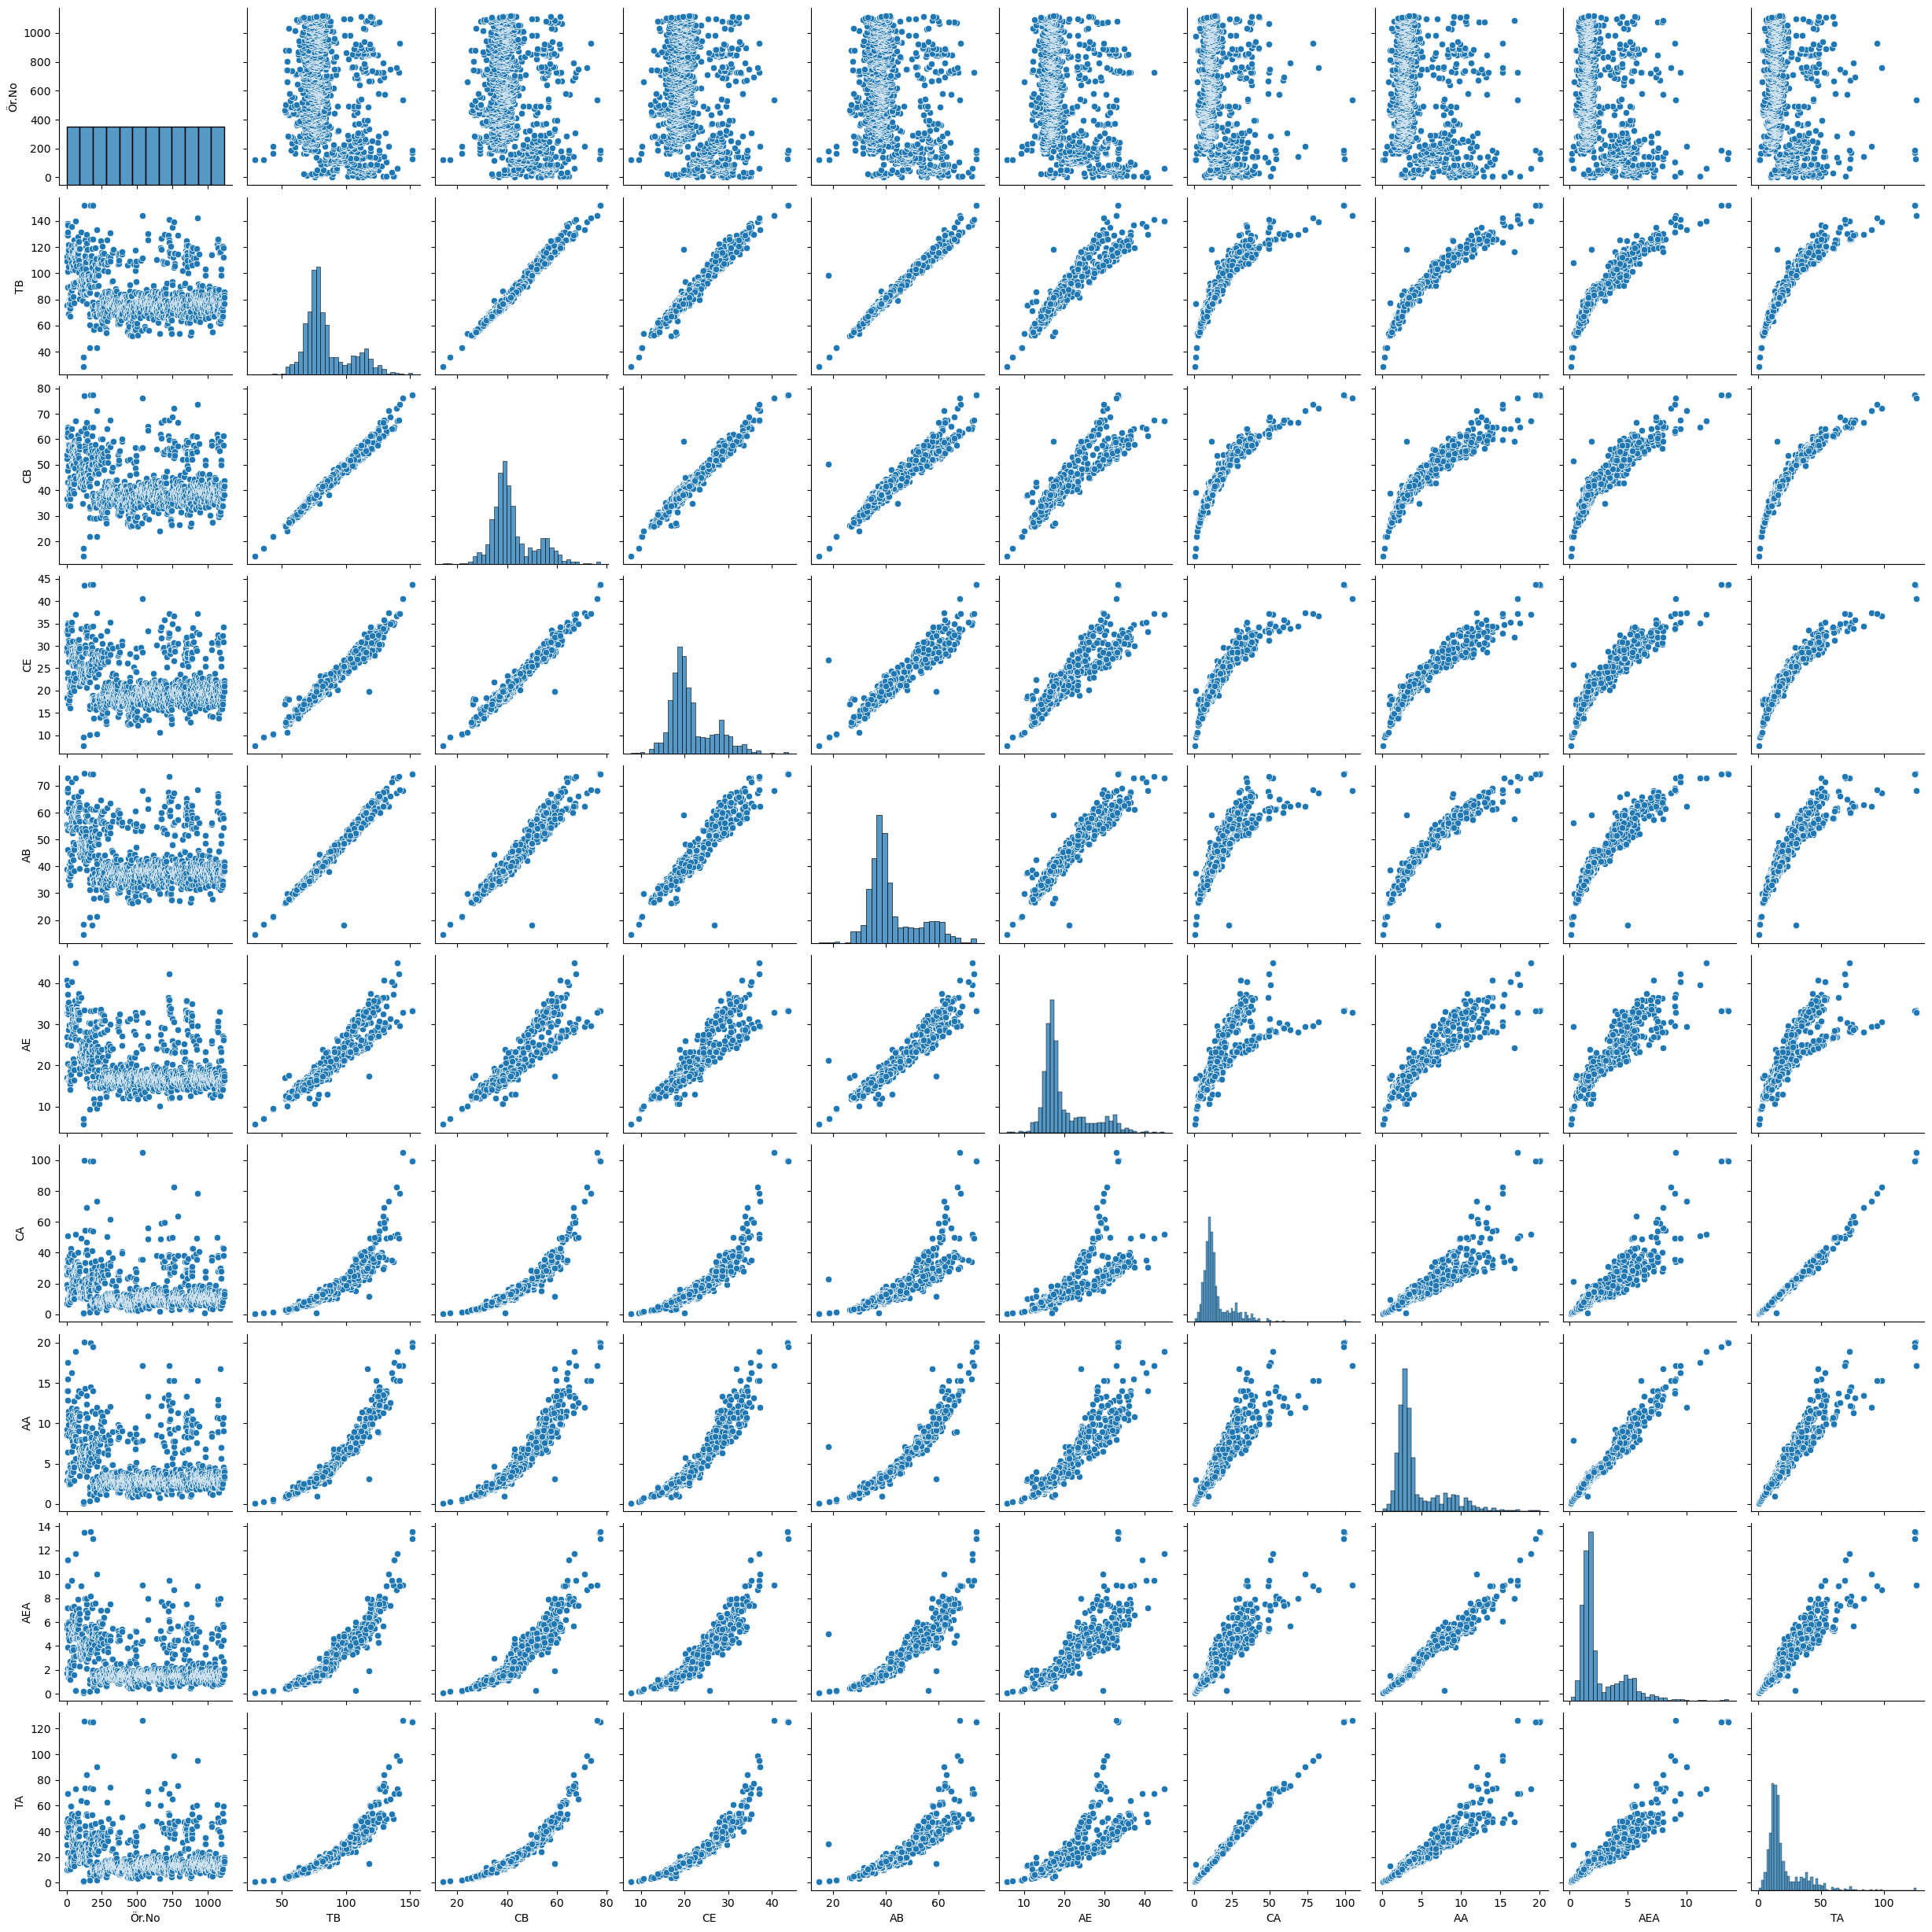

In [5]:
# Korelasyon matrisi ve ısı haritası
plt.figure(figsize=(12, 8))
correlation_matrix_variance = df_variance_selected.corr()
sns.heatmap(correlation_matrix_variance, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Seçilen Değişkenlerin Korelasyon Matrisi (Varyans Tabanlı)")
plt.show()

# Saçılım matrisi (pairplot)
sns.pairplot(df_variance_selected)
plt.show()

## Lasso Regresyon Tabanlı Seçim

In [6]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Bağımsız ve bağımlı değişkenleri ayırma
X = df_variance_selected.drop('TA', axis=1)  # 'TA' hedef değişken olduğu için çıkarılıyor
y = df_variance_selected['TA']

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verileri ölçeklendirme (Lasso için gerekli)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lasso modeli oluşturma ve eğitme
lasso = Lasso(alpha=0.01, random_state=42)  # Alpha ceza katsayısıdır, gerekirse ayarlanabilir
lasso.fit(X_train_scaled, y_train)

# Seçilen değişkenler (Lasso ağırlığı sıfır olmayanlar)
selected_features_lasso = X.columns[(lasso.coef_ != 0)]
print("Lasso Regresyon ile Seçilen Değişkenler:", selected_features_lasso)

# Yeni bir veri çerçevesi oluşturma
df_lasso_selected = df[selected_features_lasso]

Lasso Regresyon ile Seçilen Değişkenler: Index(['Ör.No', 'CE', 'AB', 'AE', 'CA', 'AA', 'AEA'], dtype='object')


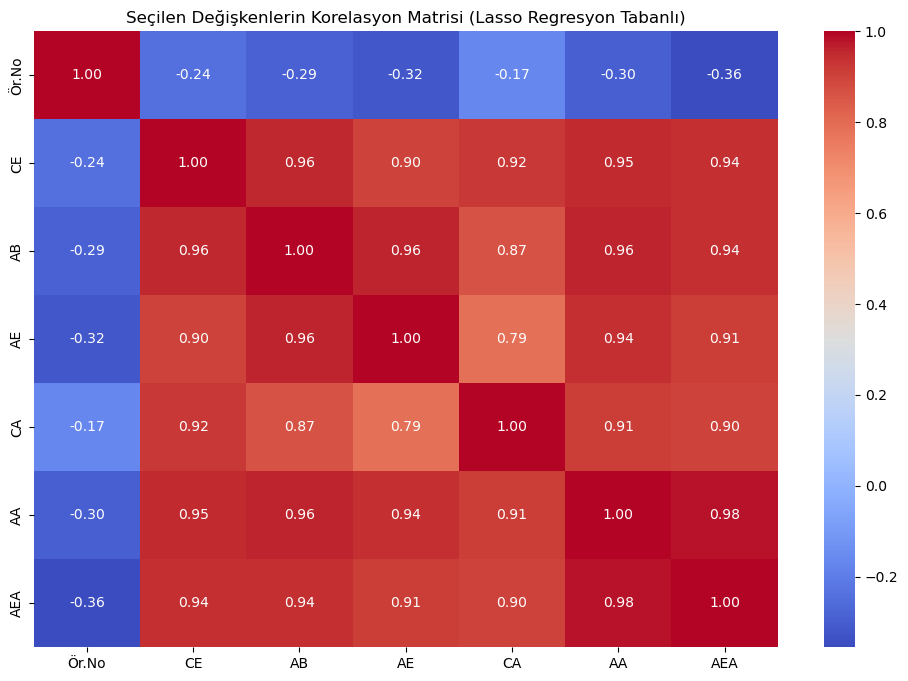

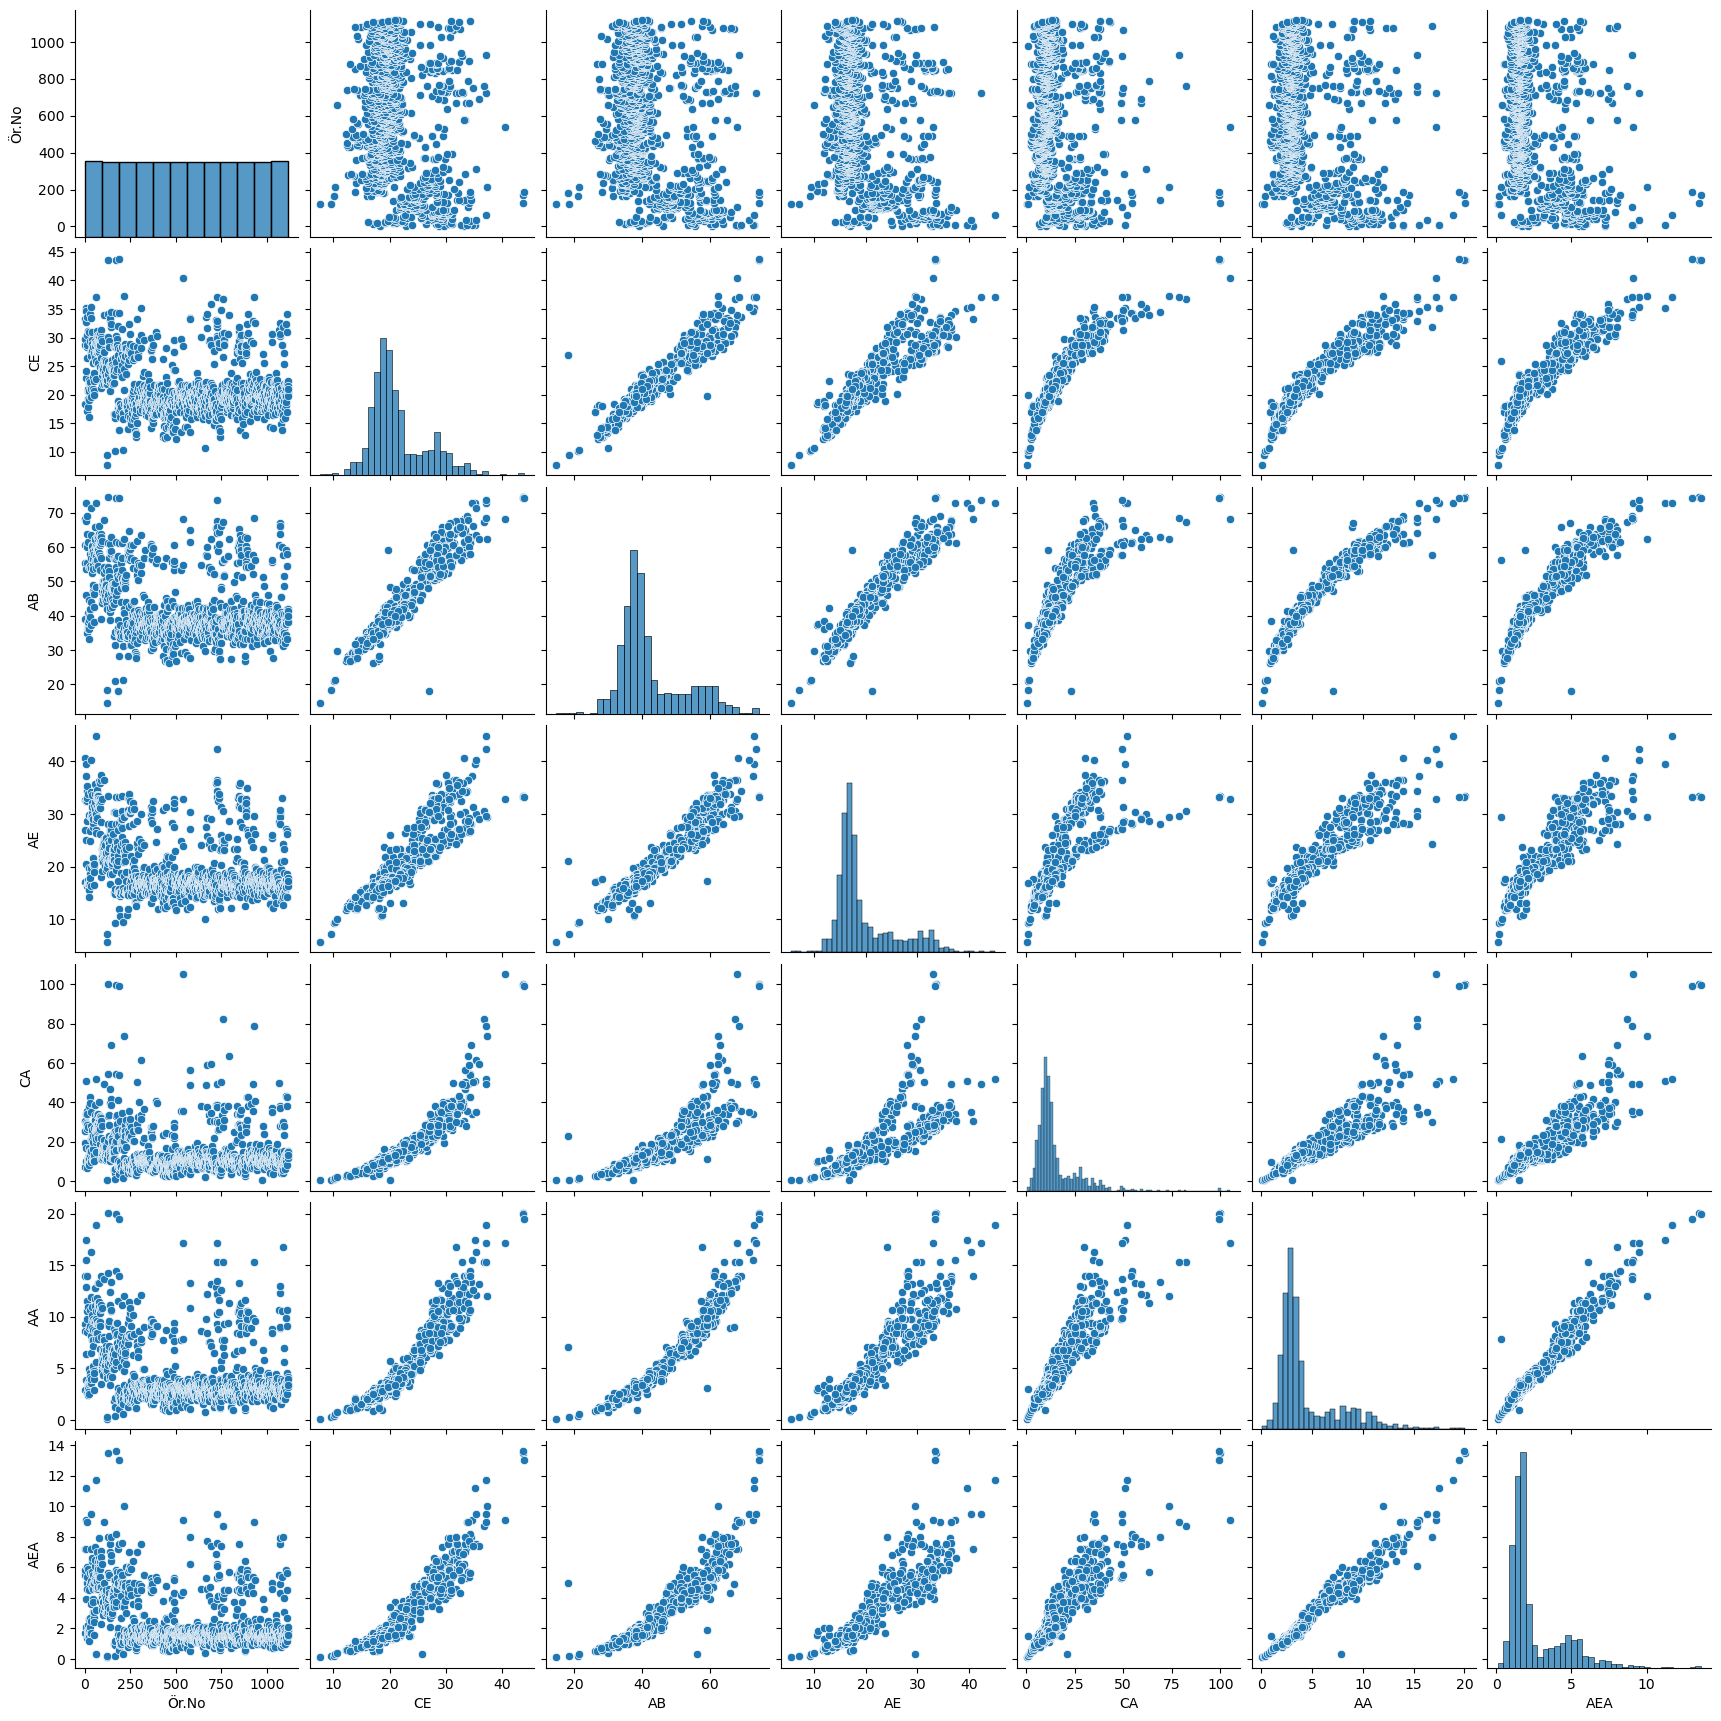

In [7]:
# Korelasyon matrisi ve ısı haritası
plt.figure(figsize=(12, 8))
correlation_matrix_lasso = df_lasso_selected.corr()
sns.heatmap(correlation_matrix_lasso, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Seçilen Değişkenlerin Korelasyon Matrisi (Lasso Regresyon Tabanlı)")
plt.show()

# Saçılım matrisi (pairplot)
sns.pairplot(df_lasso_selected)
plt.show()

## 1. Doğrusal Regresyon

Doğrusal Regresyon Performans Metrikleri:
MAE: 0.37029993555206847
MSE: 0.6445797618561132
RMSE: 0.8028572487410904
R2 Skoru: 0.9969900415349622


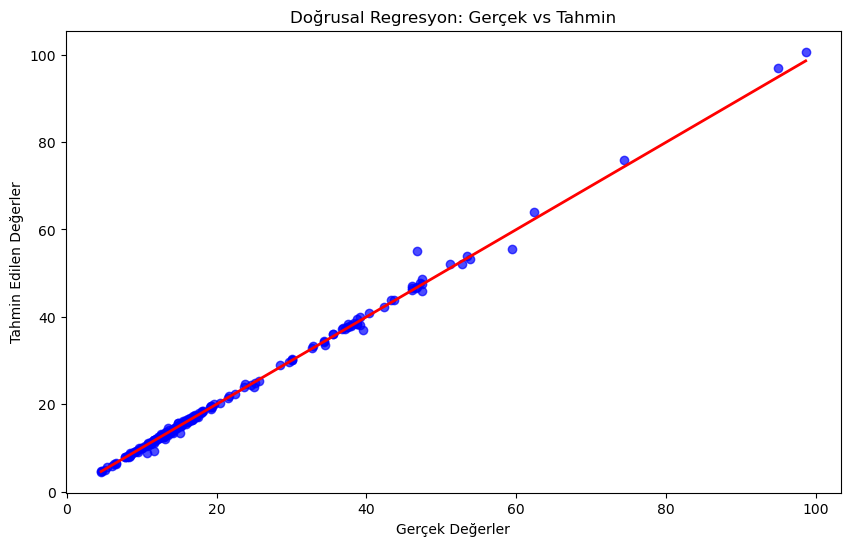

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Doğrusal Regresyon Modeli
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Tahminler
y_pred_train = linear_model.predict(X_train_scaled)
y_pred_test = linear_model.predict(X_test_scaled)

# Performans Metrikleri (Test Verisi Üzerinde)
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)

print("Doğrusal Regresyon Performans Metrikleri:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2 Skoru: {r2}")

# Tahmin ve Gerçek Değerler Grafiği
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r', lw=2)
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Edilen Değerler")
plt.title("Doğrusal Regresyon: Gerçek vs Tahmin")
plt.show()

## 2. Karar Ağaçları


Karar Ağacı Performans Metrikleri:
MAE: 0.6870535714285716
MSE: 2.4089732142857154
RMSE: 1.5520867289831826
R2 Skoru: 0.9887509510110755


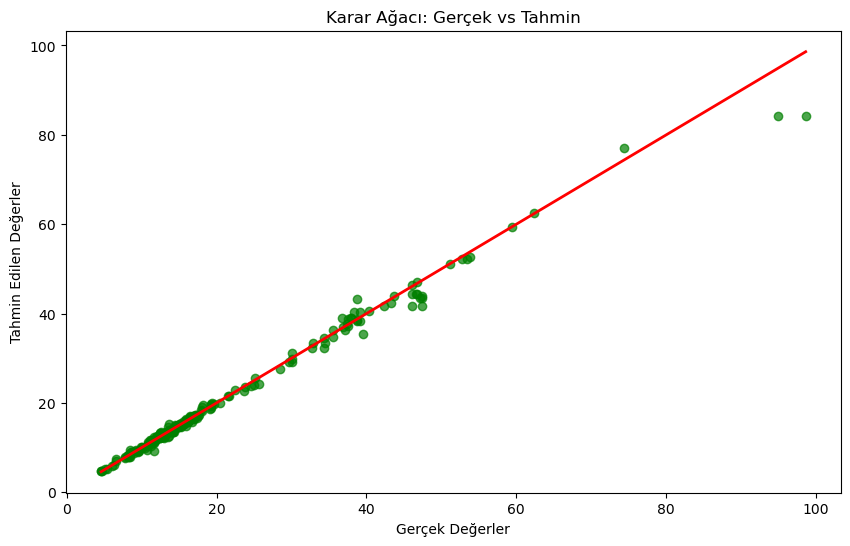

In [9]:
from sklearn.tree import DecisionTreeRegressor

# Karar Ağacı Modeli
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

# Tahminler
y_pred_tree = tree_model.predict(X_test)

# Performans Metrikleri
mae_tree = mean_absolute_error(y_test, y_pred_tree)
mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse_tree = np.sqrt(mse_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print("\nKarar Ağacı Performans Metrikleri:")
print(f"MAE: {mae_tree}")
print(f"MSE: {mse_tree}")
print(f"RMSE: {rmse_tree}")
print(f"R2 Skoru: {r2_tree}")

# Tahmin ve Gerçek Değerler Grafiği
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_tree, alpha=0.7, color='g')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r', lw=2)
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Edilen Değerler")
plt.title("Karar Ağacı: Gerçek vs Tahmin")
plt.show()

## 3. Rastgele Ormanlar


Rastgele Orman Performans Metrikleri:
MAE: 0.5019866071428567
MSE: 1.2656974709821327
RMSE: 1.1250322088643208
R2 Skoru: 0.994089642519974


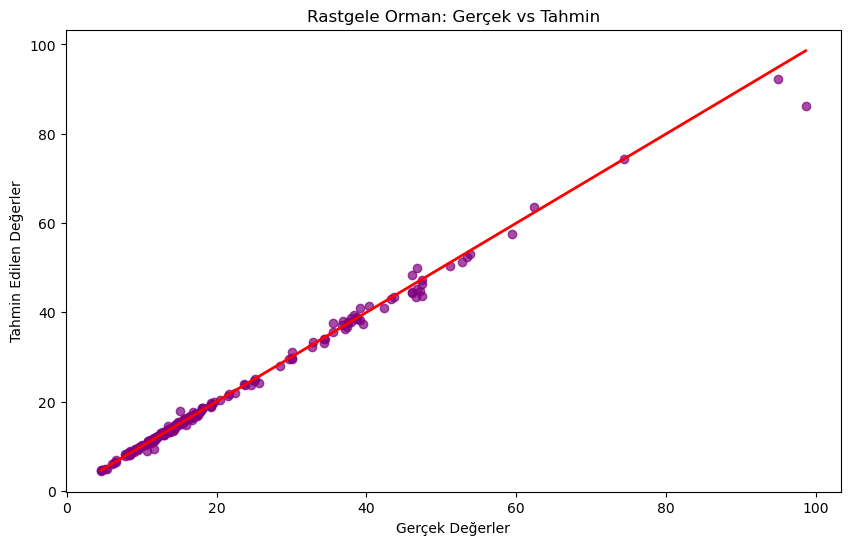

In [11]:
from sklearn.ensemble import RandomForestRegressor

# Rastgele Orman Modeli
random_forest_model = RandomForestRegressor(random_state=42, n_estimators=100)
random_forest_model.fit(X_train, y_train)

# Tahminler
y_pred_forest = random_forest_model.predict(X_test)

# Performans Metrikleri
mae_forest = mean_absolute_error(y_test, y_pred_forest)
mse_forest = mean_squared_error(y_test, y_pred_forest)
rmse_forest = np.sqrt(mse_forest)
r2_forest = r2_score(y_test, y_pred_forest)

print("\nRastgele Orman Performans Metrikleri:")
print(f"MAE: {mae_forest}")
print(f"MSE: {mse_forest}")
print(f"RMSE: {rmse_forest}")
print(f"R2 Skoru: {r2_forest}")

# Tahmin ve Gerçek Değerler Grafiği
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_forest, alpha=0.7, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r', lw=2)
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Edilen Değerler")
plt.title("Rastgele Orman: Gerçek vs Tahmin")
plt.show()

## 4. Destek Vektör Makineleri (SVM)


Destek Vektör Makineleri Performans Metrikleri:
MAE: 0.4168342440507183
MSE: 1.524618625219063
RMSE: 1.2347544797323324
R2 Skoru: 0.9928805727258361


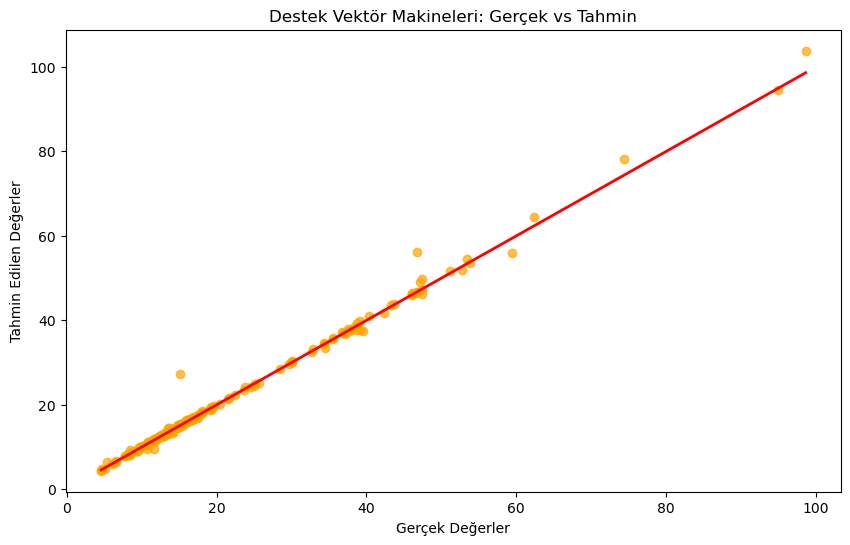

In [12]:
from sklearn.svm import SVR

# Destek Vektör Regresyon Modeli
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train)

# Tahminler
y_pred_svr = svr_model.predict(X_test_scaled)

# Performans Metrikleri
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("\nDestek Vektör Makineleri Performans Metrikleri:")
print(f"MAE: {mae_svr}")
print(f"MSE: {mse_svr}")
print(f"RMSE: {rmse_svr}")
print(f"R2 Skoru: {r2_svr}")

# Tahmin ve Gerçek Değerler Grafiği
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_svr, alpha=0.7, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r', lw=2)
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Edilen Değerler")
plt.title("Destek Vektör Makineleri: Gerçek vs Tahmin")
plt.show()

## 5. MLPRegressor (Yapay Sinir Ağları)


MLPRegressor Performans Metrikleri:
MAE: 0.4343145345128113
MSE: 0.7548416688345941
RMSE: 0.868816245724373
R2 Skoru: 0.996475157606051


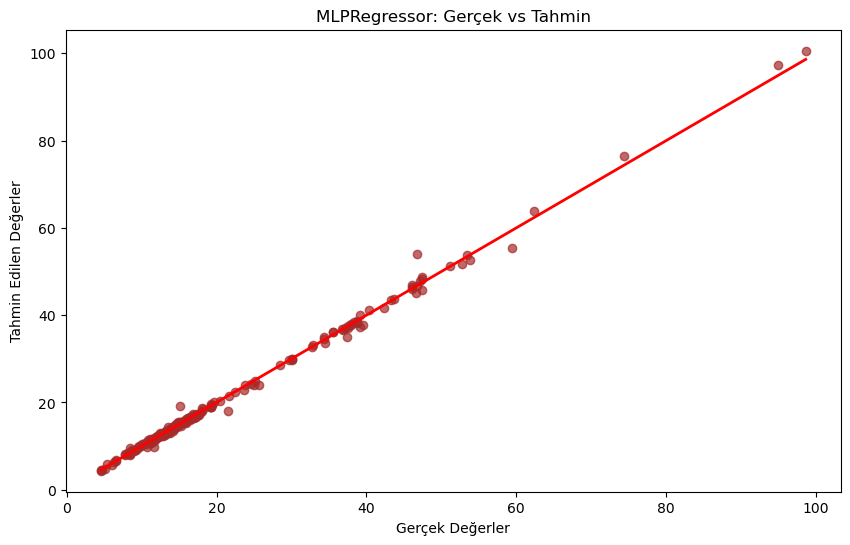

In [13]:
from sklearn.neural_network import MLPRegressor

# MLPRegressor Modeli
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42, 
                         activation='relu', solver='adam')
mlp_model.fit(X_train_scaled, y_train)

# Tahminler
y_pred_mlp = mlp_model.predict(X_test_scaled)

# Performans Metrikleri
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
rmse_mlp = np.sqrt(mse_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print("\nMLPRegressor Performans Metrikleri:")
print(f"MAE: {mae_mlp}")
print(f"MSE: {mse_mlp}")
print(f"RMSE: {rmse_mlp}")
print(f"R2 Skoru: {r2_mlp}")

# Tahmin ve Gerçek Değerler Grafiği
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_mlp, alpha=0.7, color='brown')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r', lw=2)
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Edilen Değerler")
plt.title("MLPRegressor: Gerçek vs Tahmin")
plt.show()

## Performans Karşılaştırma Tablosu

Model Performans Karşılaştırma Tablosu:
                      Model       MAE       MSE      RMSE  R2 Skoru
0        Doğrusal Regresyon  0.370300  0.644580  0.802857  0.996990
1               Karar Ağacı  0.687054  2.408973  1.552087  0.988751
2            Rastgele Orman  0.501987  1.265697  1.125032  0.994090
3  Destek Vektör Makineleri  0.416834  1.524619  1.234754  0.992881
4              MLPRegressor  0.434315  0.754842  0.868816  0.996475


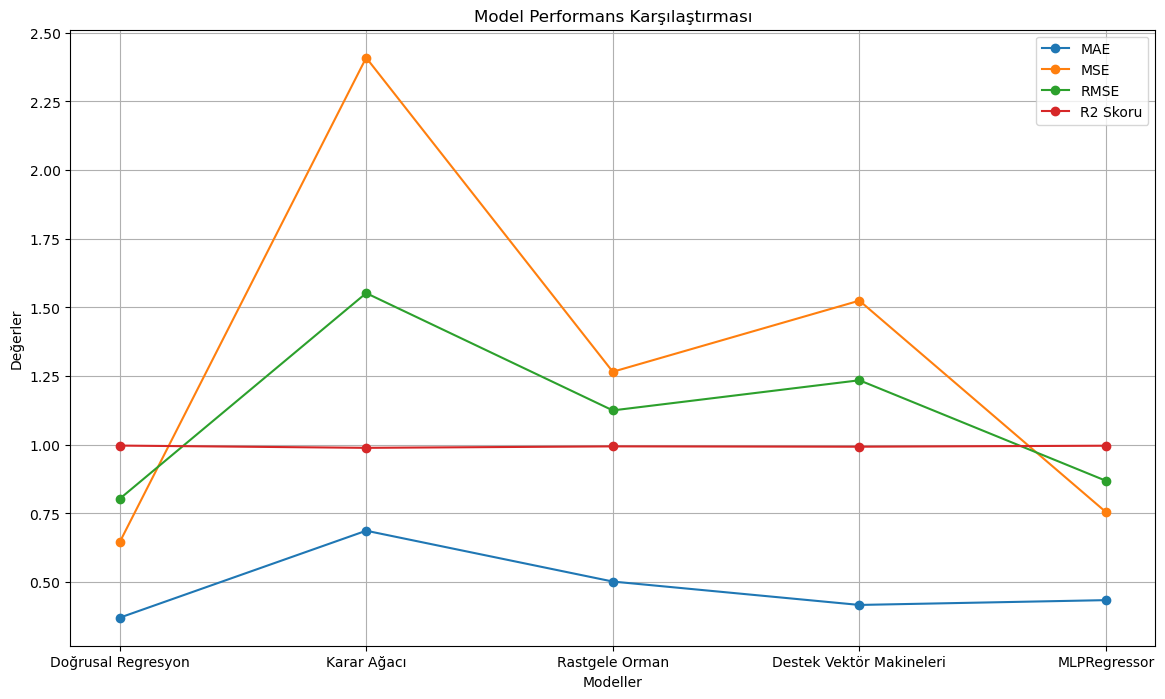

In [14]:
# Performans metriklerini bir tabloya ekleyelim
model_scores = pd.DataFrame({
    "Model": ["Doğrusal Regresyon", "Karar Ağacı", "Rastgele Orman", "Destek Vektör Makineleri", "MLPRegressor"],
    "MAE": [mae, mae_tree, mae_forest, mae_svr, mae_mlp],
    "MSE": [mse, mse_tree, mse_forest, mse_svr, mse_mlp],
    "RMSE": [rmse, rmse_tree, rmse_forest, rmse_svr, rmse_mlp],
    "R2 Skoru": [r2, r2_tree, r2_forest, r2_svr, r2_mlp]
})

# Tabloyu yazdırma
print("Model Performans Karşılaştırma Tablosu:")
print(model_scores)

# Performans metriklerini görselleştirme
plt.figure(figsize=(14, 8))
for metric in ["MAE", "MSE", "RMSE", "R2 Skoru"]:
    plt.plot(model_scores["Model"], model_scores[metric], marker='o', label=metric)

plt.title("Model Performans Karşılaştırması")
plt.xlabel("Modeller")
plt.ylabel("Değerler")
plt.legend()
plt.grid(True)
plt.show()

## TA Değerini Etkileyen Faktörlerin Analizi

Rastgele Orman Özellik Önem Dereceleri:
  Feature  Importance
6      CA    0.854680
2      CB    0.099228
3      CE    0.018507
1      TB    0.018190
7      AA    0.003278
4      AB    0.003229
8     AEA    0.002278
5      AE    0.000332
0   Ör.No    0.000277


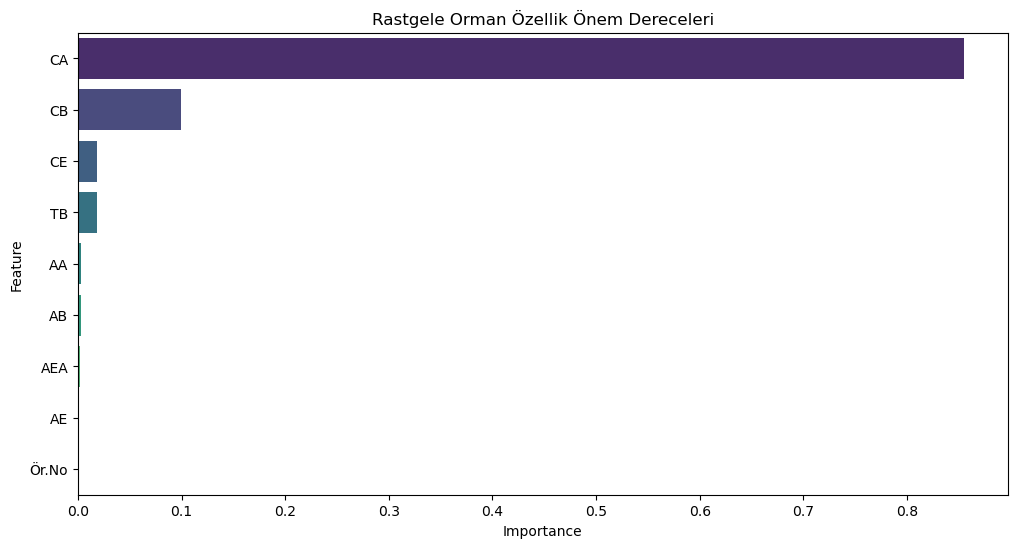

In [15]:
# Özellik önem derecelerini alalım
feature_importances = random_forest_model.feature_importances_
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

print("Rastgele Orman Özellik Önem Dereceleri:")
print(importance_df)

# Görselleştirme
plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Rastgele Orman Özellik Önem Dereceleri")
plt.show()

## Tahmin ve Gerçek Değerler Karşılaştırma Grafikleri

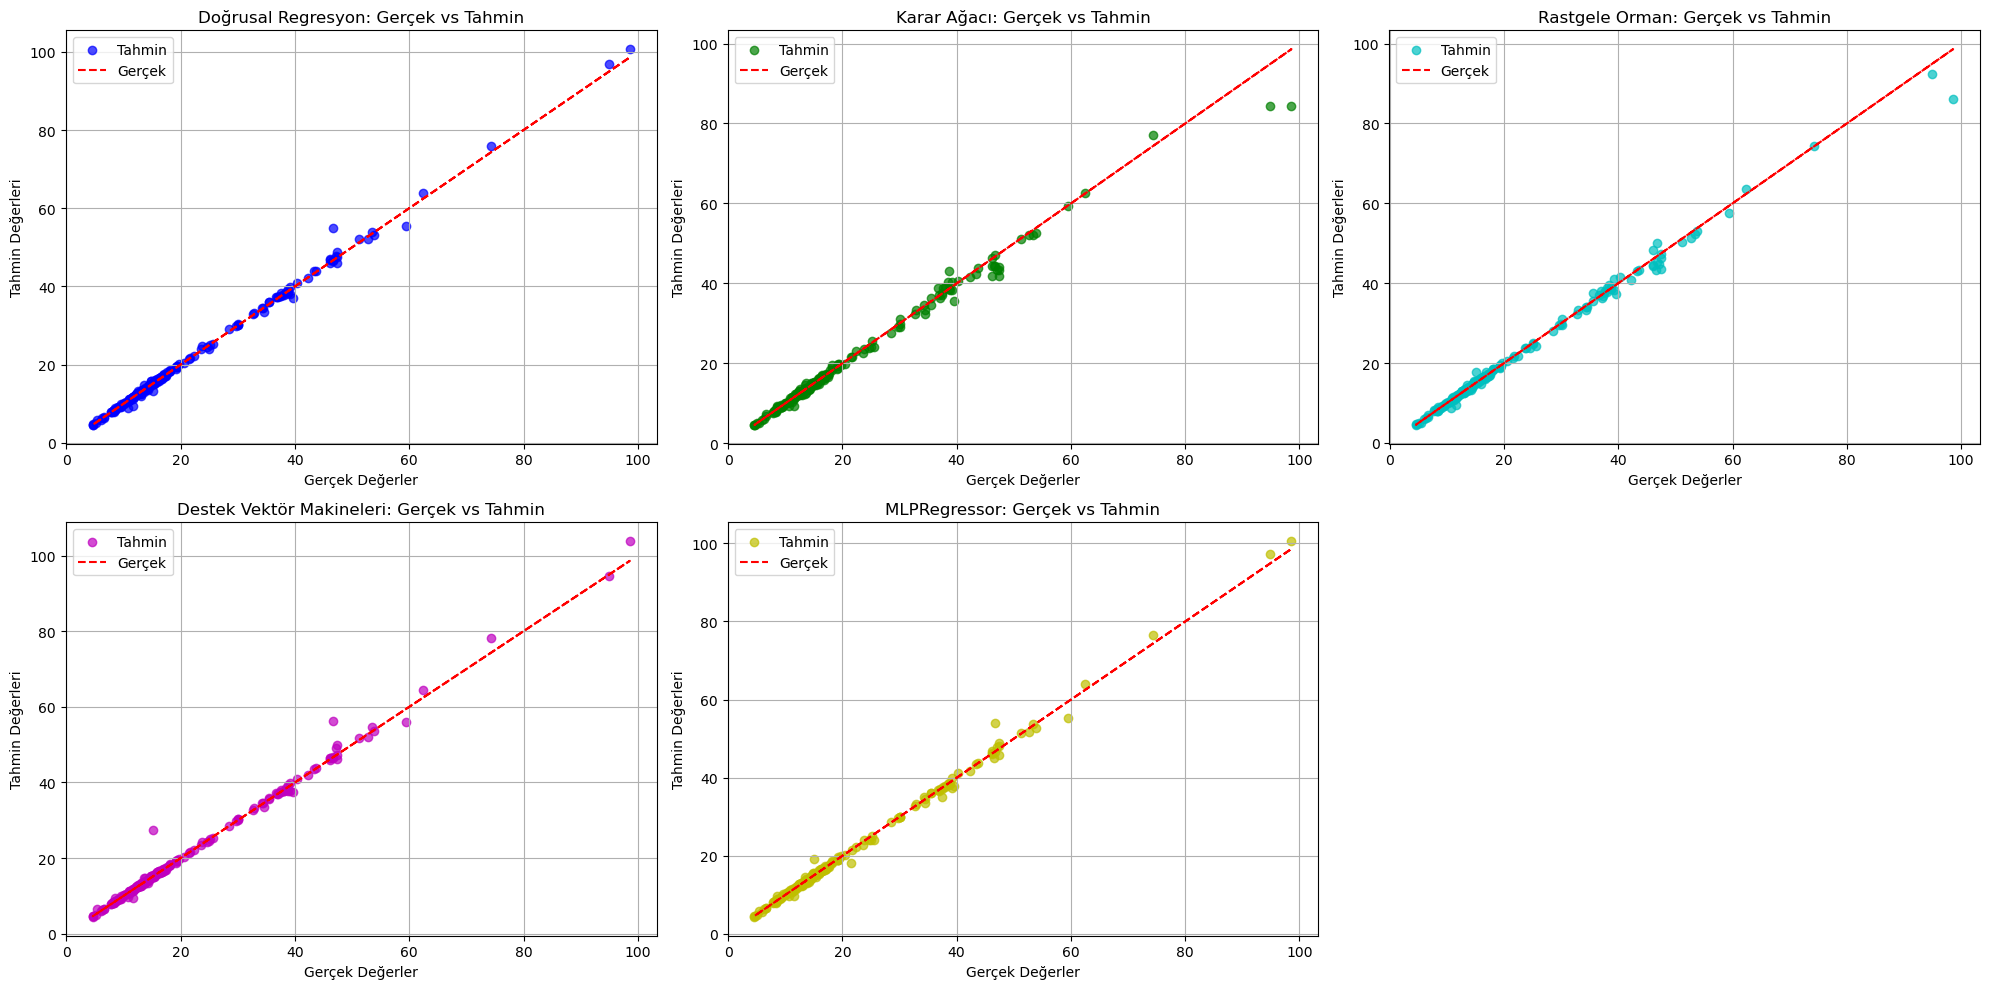

In [16]:
# Gerçek ve tahmin edilen değerler için görselleştirme
plt.figure(figsize=(20, 10))

# Doğrusal Regresyon
plt.subplot(2, 3, 1)
plt.scatter(y_test, y_pred_test, alpha=0.7, color='b', label="Tahmin")
plt.plot(y_test, y_test, color="r", linestyle="--", label="Gerçek")
plt.title("Doğrusal Regresyon: Gerçek vs Tahmin")
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Değerleri")
plt.legend()
plt.grid()

# Karar Ağacı
plt.subplot(2, 3, 2)
plt.scatter(y_test, y_pred_tree, alpha=0.7, color='g', label="Tahmin")
plt.plot(y_test, y_test, color="r", linestyle="--", label="Gerçek")
plt.title("Karar Ağacı: Gerçek vs Tahmin")
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Değerleri")
plt.legend()
plt.grid()

# Rastgele Orman
plt.subplot(2, 3, 3)
plt.scatter(y_test, y_pred_forest, alpha=0.7, color='c', label="Tahmin")
plt.plot(y_test, y_test, color="r", linestyle="--", label="Gerçek")
plt.title("Rastgele Orman: Gerçek vs Tahmin")
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Değerleri")
plt.legend()
plt.grid()

# Destek Vektör Makineleri
plt.subplot(2, 3, 4)
plt.scatter(y_test, y_pred_svr, alpha=0.7, color='m', label="Tahmin")
plt.plot(y_test, y_test, color="r", linestyle="--", label="Gerçek")
plt.title("Destek Vektör Makineleri: Gerçek vs Tahmin")
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Değerleri")
plt.legend()
plt.grid()

# MLPRegressor
plt.subplot(2, 3, 5)
plt.scatter(y_test, y_pred_mlp, alpha=0.7, color='y', label="Tahmin")
plt.plot(y_test, y_test, color="r", linestyle="--", label="Gerçek")
plt.title("MLPRegressor: Gerçek vs Tahmin")
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Değerleri")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## Kerevit Popülasyonu Tahmini ve Grafikler

Toplam Popülasyon: 1118
Dişi Popülasyon: 387
Erkek Popülasyon: 731
Avlanabilir Toplam Popülasyon: 90
Avlanabilir Dişi Popülasyon: 60
Avlanabilir Erkek Popülasyon: 30
Toplam Tahmini Ağırlık: 2518.55
Dişi Tahmini Ağırlık: 1093.0
Erkek Tahmini Ağırlık: 1425.55
Avlanabilir Tahmini Ağırlık: 560.8000000000001
Avlanabilir Dişi Tahmini Ağırlık: 361.1
Avlanabilir Erkek Tahmini Ağırlık: 199.70000000000002


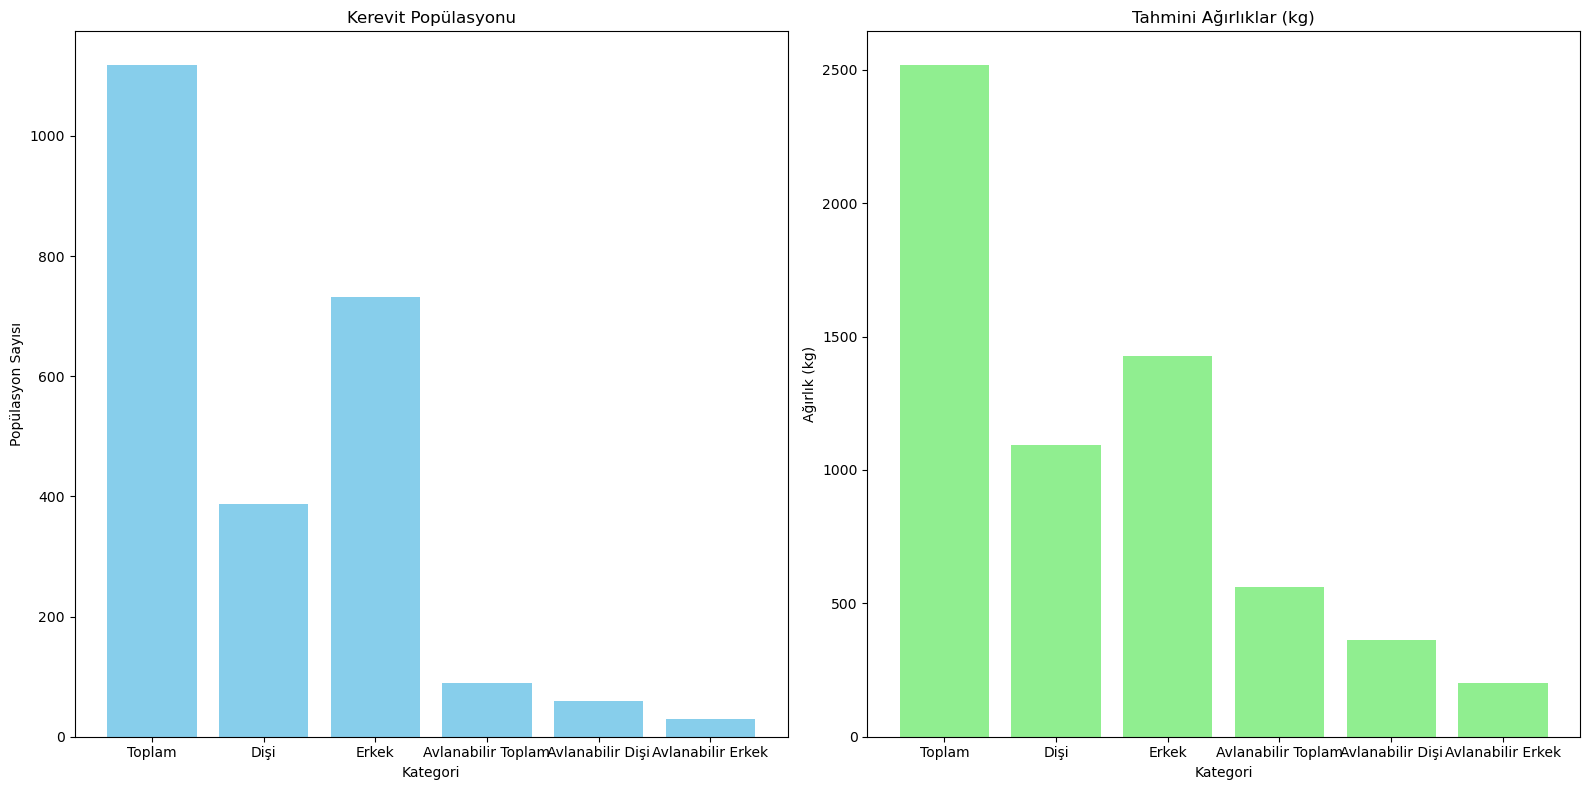

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Veri kümesinin "Eşey" (cinsiyet), "AA" (boyut cm) gibi gerekli sütunlarla yüklendiğini varsayıyoruz.

# Avlanabilir boyut tanımı (>= 10 cm)
avlanabilir_boyut = 10

# Avlanabilir sütununu veri kümesine ekliyoruz
df['Avlanabilir'] = df['AA'] >= avlanabilir_boyut

# Popülasyon istatistiklerini hesaplayalım
toplam_populasyon = df.shape[0]
disi_populasyon = df[df['Eşey'] == 'D'].shape[0]
erkek_populasyon = df[df['Eşey'] == 'E'].shape[0]
avlanabilir_toplam_populasyon = df[df['Avlanabilir']].shape[0]
avlanabilir_disi_populasyon = df[(df['Eşey'] == 'D') & (df['Avlanabilir'])].shape[0]
avlanabilir_erkek_populasyon = df[(df['Eşey'] == 'E') & (df['Avlanabilir'])].shape[0]

# Ağırlıkları tahmin etmek için basit bir formül kullanıyoruz (boyut cm * 0.5)
df['Tahmini_Agirlik'] = df['AA'] * 0.5

# Toplam ve kategori bazında tahmini ağırlıkları hesaplayalım
toplam_tahmini_agirlik = df['Tahmini_Agirlik'].sum()
disi_tahmini_agirlik = df[df['Eşey'] == 'D']['Tahmini_Agirlik'].sum()
erkek_tahmini_agirlik = df[df['Eşey'] == 'E']['Tahmini_Agirlik'].sum()
avlanabilir_tahmini_agirlik = df[df['Avlanabilir']]['Tahmini_Agirlik'].sum()
avlanabilir_disi_tahmini_agirlik = df[(df['Eşey'] == 'D') & (df['Avlanabilir'])]['Tahmini_Agirlik'].sum()
avlanabilir_erkek_tahmini_agirlik = df[(df['Eşey'] == 'E') & (df['Avlanabilir'])]['Tahmini_Agirlik'].sum()

# İstatistikleri yazdıralım
istatistikler = {
    "Toplam Popülasyon": toplam_populasyon,
    "Dişi Popülasyon": disi_populasyon,
    "Erkek Popülasyon": erkek_populasyon,
    "Avlanabilir Toplam Popülasyon": avlanabilir_toplam_populasyon,
    "Avlanabilir Dişi Popülasyon": avlanabilir_disi_populasyon,
    "Avlanabilir Erkek Popülasyon": avlanabilir_erkek_populasyon,
    "Toplam Tahmini Ağırlık": toplam_tahmini_agirlik,
    "Dişi Tahmini Ağırlık": disi_tahmini_agirlik,
    "Erkek Tahmini Ağırlık": erkek_tahmini_agirlik,
    "Avlanabilir Tahmini Ağırlık": avlanabilir_tahmini_agirlik,
    "Avlanabilir Dişi Tahmini Ağırlık": avlanabilir_disi_tahmini_agirlik,
    "Avlanabilir Erkek Tahmini Ağırlık": avlanabilir_erkek_tahmini_agirlik
}

for anahtar, deger in istatistikler.items():
    print(f"{anahtar}: {deger}")

# Görselleştirme
kategoriler = ['Toplam', 'Dişi', 'Erkek', 'Avlanabilir Toplam', 'Avlanabilir Dişi', 'Avlanabilir Erkek']
populasyon_degerleri = [
    toplam_populasyon, 
    disi_populasyon, 
    erkek_populasyon, 
    avlanabilir_toplam_populasyon, 
    avlanabilir_disi_populasyon, 
    avlanabilir_erkek_populasyon
]
agirlik_degerleri = [
    toplam_tahmini_agirlik, 
    disi_tahmini_agirlik, 
    erkek_tahmini_agirlik, 
    avlanabilir_tahmini_agirlik, 
    avlanabilir_disi_tahmini_agirlik, 
    avlanabilir_erkek_tahmini_agirlik
]

fig, eksenler = plt.subplots(1, 2, figsize=(16, 8))

# Popülasyon için bar grafiği
eksenler[0].bar(kategoriler, populasyon_degerleri, color='skyblue')
eksenler[0].set_title("Kerevit Popülasyonu")
eksenler[0].set_ylabel("Popülasyon Sayısı")
eksenler[0].set_xlabel("Kategori")

# Ağırlıklar için bar grafiği
eksenler[1].bar(kategoriler, agirlik_degerleri, color='lightgreen')
eksenler[1].set_title("Tahmini Ağırlıklar (kg)")
eksenler[1].set_ylabel("Ağırlık (kg)")
eksenler[1].set_xlabel("Kategori")

plt.tight_layout()
plt.show()

Kerevit popülasyonunun büyüklük, cinsiyet ve avlanabilirlik kriterlerine göre analizini içermektedir. Ayrıca, popülasyondaki bireylerin tahmini ağırlıkları hesaplanarak hem toplam hem de alt gruplar için öngörüler yapılmıştır.

## İstatistiksel Veriler

Toplam Popülasyon: 1118

- Dişi Popülasyon: 387

- Erkek Popülasyon: 731

- Avlanabilir Toplam Popülasyon: 90

- Avlanabilir Dişi Popülasyon: 60

- Avlanabilir Erkek Popülasyon: 30

- Toplam Tahmini Ağırlık: 2518.55 kg

- Dişi Tahmini Ağırlık: 1093.00 kg

- Erkek Tahmini Ağırlık: 1425.55 kg

- Avlanabilir Tahmini Ağırlık: 560.80 kg

- Avlanabilir Dişi Tahmini Ağırlık: 361.10 kg

- Avlanabilir Erkek Tahmini Ağırlık: 199.70 kg

## Grafiksel Analiz

Kerevit Popülasyonu: Toplam, dişi, erkek ve avlanabilir bireyler için popülasyon sayıları karşılaştırılmıştır.

Tahmini Ağırlıklar: Aynı kategoriler için toplam ağırlıklar karşılaştırılmıştır.


## Sonuç
- Toplam popülasyonun önemli bir kısmını erkek bireyler oluşturmaktadır.

- Avlanabilir bireyler, toplam popülasyonun küçük bir kısmını oluştursa da bu bireylerin dişi ağırlığı daha yüksektir.

- Toplam tahmini ağırlığın büyük bölümü erkek bireylerden gelmektedir.